# **Código Escaleras y Rodaderos**

Este proyecto representa una versión simplificada del juego de mesa Serpientes y Escaleras. El juego es una competencia para llegar a la casilla final de un tablero, si un jugador cae en una escalera, subirá, pero si cae en un rodadero caerá.

### **¿Cómo funciona?**
En esta versión se realizó una gran simplificación donde únicamente se creó un único jugador (un agente), que se moverá por un tablero de 10x10 casillas. El agente solo podrá realizar dos movimientos: avanzar a la casilla derecha o a la casilla izquierda.

El tablero tiene ciertas casillas especiales (Resaltadas en rojo) que son trampas, donde el juego termina si el agente llega a ellas, resultando en una derrota. Otras casillas son de victoria (Resaltadas en verde -Gráfica 1), que, al ser alcanzadas, finalizan el juego con una victoria.

Las escaleras (Resaltadas en azul) y los rodaderos (Resaltados en anaranjado) también están predefinidos, y si el agente aterriza en el inicio de alguno de los dos, será inmediatamente transportado hasta su final.

A continuación se presenta la ilustración del tablero de escaleras y rodaderos:

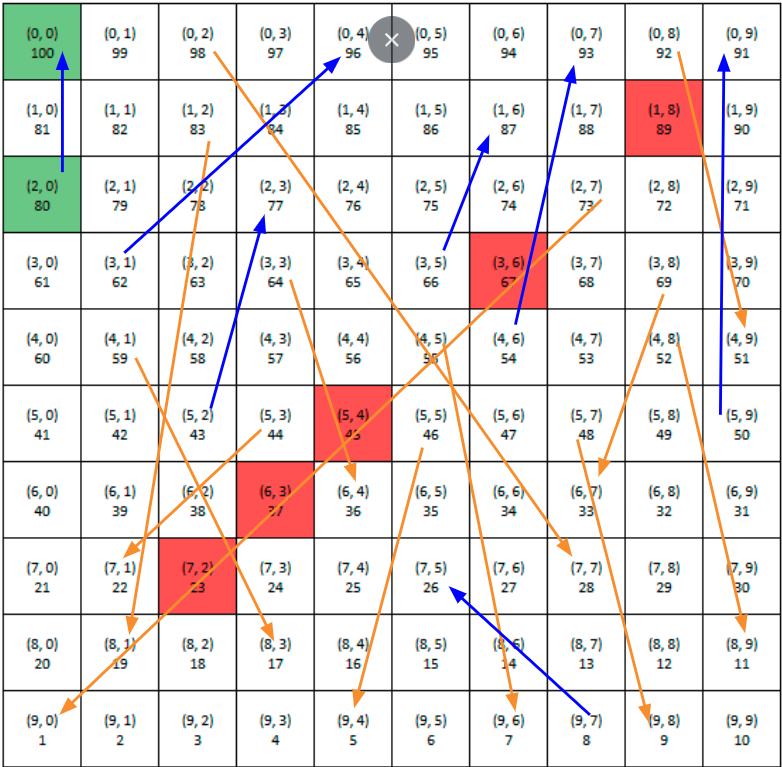

## **Definición del Ambiente y el Agente**

### **Ambiente SnakesLadders**

La clase SnakesLadders describe la esencia del juego de Serpientes y Escaleras. Esta se encarga de gestionar el tablero del juego y los movimientos del agente.

Una vez iniciado el tablero se observan las dimensiones del tablero que describe la ubicación de los rodaderos, escaleras, trampas y casillas de victoria. Esta información es la clave para configurar internamente el tablero, en tanto asigna valores de recompensa específicas a cada tipo de casilla especial, las recompensas para las victorias y las penalizaciones por las trampas.

Esta clase, de igual modo implementa métodos para que el agente pueda interactuar con el tablero, como el estado actual del agente, el valor de recompensa de una casilla, o pedir las acciones que el agente puede realizar desde su posición actual.

Las posibilidades de movimiento (izquierda/derecha) y la capacidad de reiniciar el juego a su estado inicial y verificar si el agente caé en un estado terminal fueron definidas en esta clase.



In [ ]:
VICTORY_REWARD = 100
LOSS_REWARD = -15
STEP_REWARD = -1

class SnakesLadders:

    def __init__(self, board:list[list[str]], dimensions:tuple[int,int], initial_state:tuple[int, int]):
        self.nrows, self.ncols = dimensions
        self.initial_state = initial_state
        self.state = initial_state
        snakes, ladders, sinks, victories = self._parse_board(board)
        self.sinks = {(int(point[0]), int(point[1])) for point in sinks}
        self.victories = {(int(point[0]), int(point[1])) for point in victories}
        self.snakes = {(int(x_start), int(y_start)): (int(x_end), int(y_end)) for x_start, y_start, x_end, y_end in snakes}
        self.ladders = {(int(x_start), int(y_start)): (int(x_end), int(y_end)) for x_start, y_start, x_end, y_end in ladders}
        self.grid = [[STEP_REWARD for _ in range(self.ncols)] for _ in range(self.nrows)]
        for i in range(self.nrows):
            for j in range(self.ncols):
                if (i, j) in self.sinks:
                    self.grid[i][j] = LOSS_REWARD
                elif(i, j) in self.victories:
                    self.grid[i][j] = VICTORY_REWARD

    def get_states(self) -> list[list[int]]:
        return self.grid

    def get_current_state(self) -> tuple[int, int]:
        return self.state

    def state_value(self, state:tuple[int, int]) -> float:
        return self.grid[state[0]][state[1]]

    def get_possible_actions(self, state:tuple[int,int]) -> list[str]:
        actions = ['right', 'left']
        if state == (self.nrows -1, 0):
            actions.remove('left')
        return actions

    def do_action(self, action:str) -> tuple[float, tuple[int,int]]:
        i, j = self.get_current_state()

        if action == 'left':
            if (i, j) == (self.nrows-1, 0):
                pass
            elif j > 0:
                j -= 1
            else:
                if i % 2 == 0:
                    i -= 1
                else:
                    i += 1
        elif action == 'right':
            if j < self.ncols-1:
                j += 1
            else:
                if i % 2 == 0:
                    i += 1
                else:
                    i -= 1

        # Special cases. Ladders and snakes don't use an additional turn.
        if (i, j) in self.ladders:
            i, j = self.ladders[(i,j)]
        elif (i, j) in self.snakes:
            i, j = self.snakes[(i,j)]

        self.state = (i,j)
        reward = self.grid[i][j]
        return reward, self.state

    def reset(self):
        self.state = self.initial_state

    def is_terminal(self, state:tuple[int,int]=None) -> bool:
        if state == None:
            state = self.get_current_state()
        return self.state_value(state) in (VICTORY_REWARD, LOSS_REWARD)

    def _parse_board(self, board: list[list[str]]):
        n_snakes, m_ladders, s_sinks, t_victories = board[0]
        last_snake = 1 + int(n_snakes)
        last_ladder = last_snake + int(m_ladders)
        last_sink = last_ladder + int(s_sinks)
        last_victory = last_sink + int(t_victories)

        snakes = board[1:last_snake]
        ladders = board[last_snake:last_ladder]
        sinks = board[last_ladder:last_sink]
        victories = board[last_sink:last_victory]
        return snakes, ladders, sinks, victories

### **Agente Qlearning - El Cerebro**

La clase Qlearning, o el agente, representa el cerebro del jugador en el juego. Su trabajo principal es aprender la mejor estrategia para moverse por el tablero (elegir entre "izquierda" y "derecha") con el objetivo de ganar.

La clase se llama Qlearning porque el agente utiliza una técnica llamada Q-learning para aprender. Esta clase mantiene una tabla interna donde registra qué tan buenas son ciertas acciones en diferentes casillas del tablero. Esta tabla le permite decidir su próximo movimiento con base en el conocimiento adquirido.

Algunas veces, el agente explorará nuevas acciones para descubrir mejores caminos, y otras veces utilizará lo que ya ha aprendido para tomar la acción que cree que le dará la mayor recompensa. La decisión dependerá de la parametrización especificada. De esta manera, el agente mejorará su inteligencia y su forma de jugar en cada partida.

In [ ]:
#Agente de Q-learning
import random

class QLearning:
    def __init__(self, env, epsilon=0.9, gamma=0.9, alpha=0.5):
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.qtable = {}

    def get_value(self, state:tuple[int,int], action:str) -> float:
        return self.qtable.get((state, action), 0)

    def choose_action(self, state:tuple[int,int]) -> str:
        possible_actions = self.env.get_possible_actions(state)
        # print(f"{possible_actions=}")
        if not possible_actions:
            return ""

        action = None
        if random.random() < self.epsilon:
            action = random.choice(possible_actions)
            # print(f"random {action=}")
        else:
            action = self.best_action(state)
            # print(f"best {action=}")
        return action

    def update_values(self, state:tuple[int,int], action:str, next_state:tuple[int,int], reward:int) -> None:
        q_s_a1 = self.get_value(state, action)
        best_action = self.best_action(next_state)
        best_q_s_a2 = self.get_value(next_state, best_action)
        self.qtable[(state, action)] = (1-self.alpha)*q_s_a1 + self.alpha*(reward + self.gamma*best_q_s_a2)

    def best_action(self, state: tuple[int, int]) -> str:
        possible_actions = self.env.get_possible_actions(state)
        if not possible_actions:
            # Esto no debería suceder si el estado no es terminal y siempre hay acciones
            return "" # O manejar el error apropiadamente

        best_q_value = -float('inf')
        best_actions_list = [] # Usamos una lista para manejar empates

        for action in possible_actions:
            q_value = self.get_value(state, action) # self.get_value es eficiente (búsqueda en diccionario)

            if q_value > best_q_value:
                best_q_value = q_value
                best_actions_list = [action] # Nueva mejor acción encontrada
            elif q_value == best_q_value:
                best_actions_list.append(action) # Empate, añadir a la lista

        if not best_actions_list:
            # Si todas las acciones posibles para este estado no están en qtable (Q-valor de 0 por defecto)
            # o si possible_actions estaba vacío (aunque ya se verificó).
            # En este caso, elegimos una acción al azar de las posibles.
            return random.choice(possible_actions)
        else:
            # Si hay una o más mejores acciones (empates), elige una al azar.
            return random.choice(best_actions_list)

    def step(self, action:str) -> tuple[tuple[int,int],int, bool, str]:

        reward, next_state = self.env.do_action(action)
        is_terminal = self.env.is_terminal(next_state)
        info = ''
        return next_state, reward, is_terminal, info

    def run(self, episodes:int) -> dict[tuple[int,str],float]:
        for episode in range(episodes):
            # print(f'{episode=}')
            self.env.reset()
            done = False
            while not done:
                state = self.env.get_current_state()
                # print(f"{state=}")
                action = self.choose_action(state)
                # print(f"{action=}")
                next_state, reward, is_terminal, info = self.step(action)
                # print(f"{next_state=}{reward=}{is_terminal}")
                self.update_values(state, action, next_state, reward)
                # print(f"{self.qtable=}")
                # next_action = self.choose_action(next_state)
                state = next_state
                done = is_terminal

            if (episode + 1) % 100 == 0 and self.epsilon >= 0.01:
                self.epsilon -= self.epsilon / 10

        return self.qtable

    def test_performance(self) -> tuple[dict, dict]:
        actions = {}
        values = {}
        for i in range(self.env.nrows):
            for j in range(self.env.ncols):
                if not self.env.is_terminal((i,j)):
                    action = self.best_action((i,j))
                    actions[(i,j)] = action
                    values[(i,j)] = self.get_value((i,j), action)
        return actions, values

In [ ]:
def read_board(path: str):
    """Función auxiliar que permite leer el archivo del tablero"""
    with open(path, "r") as f:
        board = f.readlines()

    board = [line.strip().split() for line in board]
    return board

board = read_board("./tablero_snakes_ladders.txt")
board

[['12', '7', '5', '2'],
 ['0', '2', '7', '7'],
 ['0', '8', '4', '9'],
 ['1', '2', '8', '1'],
 ['2', '7', '9', '0'],
 ['3', '3', '6', '4'],
 ['3', '8', '6', '7'],
 ['4', '1', '8', '3'],
 ['4', '5', '9', '6'],
 ['4', '8', '8', '9'],
 ['5', '3', '7', '1'],
 ['5', '5', '9', '4'],
 ['5', '7', '9', '8'],
 ['2', '0', '0', '0'],
 ['3', '5', '1', '6'],
 ['3', '1', '0', '4'],
 ['4', '6', '0', '7'],
 ['5', '2', '2', '3'],
 ['5', '9', '0', '9'],
 ['9', '7', '7', '5'],
 ['1', '8'],
 ['3', '6'],
 ['5', '4'],
 ['6', '3'],
 ['7', '2'],
 ['0', '0'],
 ['2', '0']]

### **Pruebas**

In [ ]:
# Pruebas definición del ambiente

snakes_and_ladders = SnakesLadders(board, (10,10), (9,0))

assert snakes_and_ladders.ncols == 10, "El número de columnas no es correcto"
assert snakes_and_ladders.nrows == 10, "El número de filas no es correcto"
assert snakes_and_ladders.initial_state == (9,0), "El estado inicial no es correcto"

for state in snakes_and_ladders.victories:
    assert snakes_and_ladders.state_value(state) == VICTORY_REWARD, f"El valor del estado {state} no es correcto"
    assert snakes_and_ladders.is_terminal(state) == True, f"El estado {state} es terminal"

for state in snakes_and_ladders.sinks:
    assert snakes_and_ladders.state_value(state) == LOSS_REWARD, f"El valor del estado {state} no es correcto"
    assert snakes_and_ladders.is_terminal(state) == True, f"El estado {state} es terminal"

assert snakes_and_ladders.get_possible_actions((9,0)) == ['right'], "Las acciones posibles no son correctas"
assert snakes_and_ladders.get_possible_actions((3,4)) == ['right', 'left'], "Las acciones posibles no son correctas"

snakes_and_ladders.state = (9, 9)
assert snakes_and_ladders.do_action('right') == (STEP_REWARD, (8, 9)), "La acción no es correcta"
assert snakes_and_ladders.do_action('right') == (STEP_REWARD, (9, 9)), "La acción no es correcta"


In [ ]:
#Pruebas estructura del agente

agent = QLearning(snakes_and_ladders, 0.8, 0.2, 0.3)

try:
    agent.env
    assert type(agent.env) is SnakesLadders, "El ambiente debe ser de tipo SnakesLadders"
except:
    raise Exception("El atributo env no está definido")
try:
    agent.epsilon
    assert type(agent.epsilon) is float, "El valor de epsilon debe ser un número flotante"
except:
    raise Exception("El atributo epsilon no está definido")
try:
    agent.gamma
    assert type(agent.gamma) is float, "El valor del factor de descuento debe ser un número flotante"
except:
    raise Exception("El atributo gamma no está definido")
try:
    agent.alpha
    assert type(agent.alpha) is float, "El valor de epla taza de aprendizaje debe ser un número flotante"
except:
    raise Exception("El atributo alpha no está definido")
try:
    agent.qtable
    assert type(agent.qtable) is dict, "La qtable del agente debe estar definida como un mapa, incialmente vacío"
except:
    raise Exception("El atributo qtable no está definido")

assert agent.env == snakes_and_ladders, "El valor de mdp no se inicializa correctamente al MDP dado por parámetro"
assert agent.epsilon == 0.8, "El valor de epsilon no se asigna al valor pasado por parámetro 0.8, se esta utilizando {0} como valor".format(agent.epsilon)
assert agent.gamma == 0.2, "El valor de descuento no se asigna al valor pasado por parámetro 0.2, se esta utilizando {0} como valor".format(agent.gamma)
assert agent.alpha == 0.3, "El valor de la taza de aprendizaje no se asigna al valor pasado por parámetro 0.3, se esta utilizando {0} como valor".format(agent.alpha)

In [ ]:
agent = QLearning(snakes_and_ladders)

try:
    agent.get_value
    assert type(agent.get_value((1,1), 'up')) is float or type(agent.get_value((1,1), 'up')) is int, "El valor de una pareja (estado,accion) debe ser 0 inicialmente o el valor cálculado usando SARSA de lo contrario"
except:
    raise Exception("La función get_value no está definida")

assert agent.get_value((0,0),'up') == 0, "El valor inicial de una pareja (estado,acción) debe ser 0"

## **Entrenamiento del Agente**

### **Inicialización del Agente**

La siguiente función inicializa al agente (QLearning) y lo conecta al entorno SnakesLadders. Luego, el agente inicia un proceso de entrenamiento, cuyo número de partidas o episodios estará determinado por el método `agente.run(n_episodios)`.

Durante cada partida, el agente ganará experiencia, ajustará su estrategia en función de cada movimiento y recompensa, y así irá desarrollando una respuesta cada vez más óptima.

Una vez concluido el proceso de entrenamiento, se evalúa el rendimiento del agente. La función plot_policy nos muestra la política que ha aprendido, junto con los valores esperados para cada acción. El tablero visualizará la acción óptima en cada casilla, permitiendo entender cómo el agente aprendió a moverse a lo largo del tablero.

In [ ]:
# Variar los parámetros epsilon, gamma, alpha
snakes_and_ladders = SnakesLadders(board, (10,10), (9,0))

agent = QLearning(snakes_and_ladders, 0.99, 0.95, 0.55)
qtable = agent.run(50000)

policy, values = agent.test_performance()

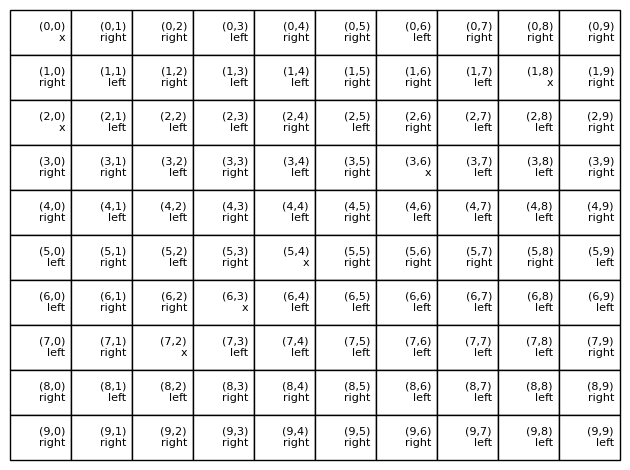

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_policy_table(policy, nrows, ncols):
    fig, ax = plt.subplots()
    ax.axis('off')  # Hide the axes

    # Prepare cell text and coordinates
    cell_text = [['' for _ in range(ncols)] for _ in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            action = policy.get((i, j), 'x')
            cell_text[i][j] = f'({i},{j})\n{action}'

    # Create the table
    table = ax.table(cellText=cell_text, loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(8)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Adjust cell height and width based on the number of rows and columns
    for (row, col), cell in table.get_celld().items():
        # if row > 0:  # Don't adjust header row if it exists
        cell.set_height(1/nrows)
        cell.set_width(1/ncols)

    plt.tight_layout()
    plt.show()


plot_policy_table(policy, agent.env.nrows, agent.env.ncols)

## **Probando el desempeño del agente entrenado. Uso de la tabla Q.**

In [ ]:
import pandas as pd
import pickle

In [ ]:
# Guardar la Q tabla
with open('./qtable.pkl', 'wb') as f:
    pickle.dump(qtable, f)

In [ ]:
# Load qtable
with open('./qtable.pkl', 'rb') as f:
    qtable_in = pickle.load(f)


# Visualizar la Q Table cargada
pd.Series(qtable_in).unstack(level=-1)

,left,right
"(6, 4)",-15.000000,-15.487328
"(6, 5)",-15.250000,-15.713125
"(6, 6)",-15.487500,-15.927469
"(6, 7)",-15.713125,-16.131095
"(6, 8)",-15.927469,-16.324541
"(6, 9)",-16.131095,-16.508314
"(7, 3)",-15.000000,-15.487500
"(7, 4)",-15.250000,-15.713125
"(7, 5)",-15.487500,-15.927469
"(7, 6)",-15.713125,-16.131095


In [ ]:
# Resultados. Simulación del estado final del agente entrenado.
with open('./qtable.pkl', 'rb') as f:
    qtable_in = pickle.load(f)


snakes_and_ladders = SnakesLadders(board, (10,10), (9,0))

agent = QLearning(snakes_and_ladders, 0, 0.95, 0.5)
agent.qtable = qtable_in

done = False
idx = 0
while not done:
    state = agent.env.get_current_state()
    # print(f"{state=}")
    action = agent.choose_action(state)
    # print(f"{action=}")
    next_state, reward, is_terminal, info = agent.step(action)
    print(f"Initial {state=} | {action=:^5} >> {next_state=} | {reward=} | {is_terminal=}")
    # agent.update_values(state, action, next_state, reward)
    state = next_state
    done = is_terminal
    idx += 1

print(f"\nNumber of steps {idx}")

print("\nTabla Q")
print("*"*40)
agent.qtable

Initial state=(9, 0) | action=right >> next_state=(9, 1) | reward=-1 | is_terminal=False
Initial state=(9, 1) | action=right >> next_state=(9, 2) | reward=-1 | is_terminal=False
Initial state=(9, 2) | action=right >> next_state=(9, 3) | reward=-1 | is_terminal=False
Initial state=(9, 3) | action=right >> next_state=(9, 4) | reward=-1 | is_terminal=False
Initial state=(9, 4) | action=right >> next_state=(9, 5) | reward=-1 | is_terminal=False
Initial state=(9, 5) | action=right >> next_state=(9, 6) | reward=-1 | is_terminal=False
Initial state=(9, 6) | action=right >> next_state=(7, 5) | reward=-1 | is_terminal=False
Initial state=(7, 5) | action=left  >> next_state=(7, 4) | reward=-1 | is_terminal=False
Initial state=(7, 4) | action=left  >> next_state=(7, 3) | reward=-1 | is_terminal=False
Initial state=(7, 3) | action=left  >> next_state=(7, 2) | reward=-15 | is_terminal=True

Number of steps 10

Tabla Q
****************************************


{((9, 0), 'right'): -16.848752951376945,
 ((9, 1), 'left'): -17.006315303808094,
 ((9, 1), 'right'): -16.682897843554677,
 ((9, 2), 'left'): -16.848752951376945,
 ((9, 2), 'right'): -16.508313519531242,
 ((9, 3), 'right'): -16.324540546874992,
 ((9, 4), 'right'): -16.131095312499994,
 ((9, 5), 'right'): -15.927468749999992,
 ((9, 6), 'right'): -15.713124999999991,
 ((7, 5), 'right'): -15.927468749999992,
 ((7, 6), 'left'): -15.713124999999991,
 ((7, 5), 'left'): -15.487499999999994,
 ((7, 4), 'right'): -15.713124999999991,
 ((7, 6), 'right'): -16.131095312499994,
 ((7, 7), 'left'): -15.927468749999992,
 ((7, 7), 'right'): -16.324540546874992,
 ((7, 8), 'right'): -16.508313519507126,
 ((7, 9), 'left'): -16.324540546874992,
 ((7, 8), 'left'): -16.131095312499994,
 ((7, 4), 'left'): -15.249999999999996,
 ((7, 3), 'left'): -14.999999999999996,
 ((9, 3), 'left'): -16.682897843554677,
 ((9, 5), 'left'): -16.324540546874992,
 ((7, 3), 'right'): -15.487499999999994,
 ((9, 6), 'left'): -16.1310

Se puede observar que, para este tablero, el agente prefiere saltar a la casilla de derrota en la posición (7, 3) a continuar moviéndose aleatoriamente, debido a que la recompensa acumulada descontada es mayor (menos negativa).